In [1]:
#Installs
!pip install transformers
!pip install transformers[sentencepiece] sacrebleu
!pip install sentence-transformers
!pip install streamlit googletrans==4.0.0-rc1
!pip install googletrans==3.1.0a0

  Using cached googletrans-4.0.0rc1-py3-none-any.whl
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.1.0a0
    Uninstalling googletrans-3.1.0a0:
      Successfully uninstalled googletrans-3.1.0a0
  Using cached googletrans-3.1.0a0-py3-none-any.whl
  Attempting uninstall: googletrans
    Found existing installation: googletrans 4.0.0rc1
    Uninstalling googletrans-4.0.0rc1:
      Successfully uninstalled googletrans-4.0.0rc1


In [2]:

#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
import nltk
import torch
import time
import googletrans
import streamlit as st
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from nltk.translate.bleu_score import corpus_bleu
from sentence_transformers import SentenceTransformer, util
from sacrebleu.metrics import CHRF
from nltk.translate.meteor_score import meteor_score
from nltk.lm import KneserNeyInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import ngrams
from googletrans import Translator
from google.colab import drive

In [3]:
translator = Translator(raise_exception=True)

In [4]:
#Load Dataset
df=pd.read_csv('./Bhagwad_Gita.csv')
hindi_sentences=df['HinMeaning'].values
english_sentences=df['EngMeaning'].values

In [5]:
df.head()

,ID,Chapter,Verse,Shloka,Transliteration,HinMeaning,EngMeaning,WordMeaning
0,BG1.1,1,1,धृतराष्ट्र उवाच |\nधर्मक्षेत्रे कुरुक्षेत्रे स...,dhṛtarāṣṭra uvāca .\ndharmakṣetre kurukṣetre s...,।।1.1।।धृतराष्ट्र ने कहा -- हे संजय ! धर्मभूमि...,1.1 Dhritarashtra said What did my people and...,1.1 धर्मक्षेत्रे on the holy plain? कुरुक्षेत्...
1,BG1.2,1,2,सञ्जय उवाच |\nदृष्ट्वा तु पाण्डवानीकं व्यूढं द...,sañjaya uvāca .\ndṛṣṭvā tu pāṇḍavānīkaṃ vyūḍha...,।।1.2।।संजय ने कहा -- पाण्डव-सैन्य की व्यूह रच...,1.2. Sanjaya said Having seen the army of the...,1.2 दृष्ट्वा having seen? तु indeed? पाण्डवानी...
2,BG1.3,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् |\n...,paśyaitāṃ pāṇḍuputrāṇāmācārya mahatīṃ camūm .\...,।।1.3।।हे आचार्य ! आपके बुद्धिमान शिष्य द्रुपद...,"1.3. ""Behold, O Teacher! this mighty army of t...",1.3 पश्य behold? एताम् this? पाण्डुपुत्राणाम् ...
3,BG1.4,1,4,अत्र शूरा महेष्वासा भीमार्जुनसमा युधि |\nयुयुध...,atra śūrā maheṣvāsā bhīmārjunasamā yudhi .\nyu...,।।1.4।।इस सेना में महान् धनुर्धारी शूर योद्धा ...,"1.4. Here are heroes, mighty archers, eal in b...",1.4 अत्र here? शूराः heroes? महेष्वासाः mighty...
4,BG1.5,1,5,धृष्टकेतुश्चेकितानः काशिराजश्च वीर्यवान् |\nपु...,dhṛṣṭaketuścekitānaḥ kāśirājaśca vīryavān .\np...,"।।1.5।।धृष्टकेतु, चेकितान, बलवान काशिराज, पुर...","1.5. ""Dhrishtaketu, chekitana and the valiant ...",1.5 धृष्टकेतुः Dhrishtaketu? चेकितानः Chekitan...


In [6]:
translator = Translator(raise_exception=True)
translatedEngHin = []
for index, (hindi, english) in enumerate(zip(hindi_sentences, english_sentences)):
    print(index+1)
    print("English:", english_sentences[index])
    translation = translator.translate(hindi, src='en', dest='hi').text
    print("Translated: ", translation)
    print("Original: ", hindi)
    print("------------------------------")
    translatedEngHin.append(translation)


1
English: 1.1 Dhritarashtra said  What did my people and the sons of Pandu do when they had assembled
together eager for battle on the holy plain of Kurukshetra, O Sanjaya.
Translated:  ।।1.1।।धृतराष्ट्र ने कहा -- हे संजय ! धर्मभूमि कुरूक्षेत्र में सम्मिलित युद्ध के उद्देश्य (युयुत्सव:) मेरे और पाण्डु के पुत्रों ने क्या किया?
Original:  ।।1.1।।धृतराष्ट्र ने कहा -- हे संजय ! धर्मभूमि कुरुक्षेत्र में एकत्र हुए युद्ध के इच्छुक (युयुत्सव:) मेरे और पाण्डु के पुत्रों ने क्या किया?
------------------------------
2
English: 1.2. Sanjaya said  Having seen the army of the Pandavas drawn up in battle-array,
King Duryodhana then approached his teacher (Drona) and spoke these words.
Translated:  1.2.संजय ने कहा--पांडव-सैन्य की दृष्टि रचना राजा दुर्योधन ने आचार्य द्रोण के पास ये वचन कहे।
Original:  ।।1.2।।संजय ने कहा -- पाण्डव-सैन्य की व्यूह रचना देखकर राजा दुर्योधन ने आचार्य द्रोण के पास जाकर ये वचन कहे।
------------------------------
3
English: 1.3. "Behold, O Teacher! this mighty army of the son

In [7]:
#Saving the results
comaparision = pd.DataFrame({'Original': hindi_sentences, 'Translated': translatedEngHin})
comaparision.to_csv('/content/BG-GOOGLETRANS-Translated-Hin_Eng.csv', index=False)

###Calculating the various accuracy scores
---
```
*   BLEU: 83.22
*   CHRF: 81.2008
*   STS: 0.8231
*   METEOR: 0.7882
*   Original Perplexity: 17.8535
*   Translated Perplexity: 18.1062
```

In [8]:
#BLEU Score
references = [[hindi] for hindi in hindi_sentences]  # Create reference list of lists
candidates = translatedEngHin  # Model translations
bleu_score = corpus_bleu(references, candidates)
print(f"BLEU score: {bleu_score:.4f}")

BLEU score: 0.8315


In [9]:
# STS Score
# Load the pre-trained model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Encode the original Hindi sentences and the translated sentences
embeddings1 = model.encode(hindi_sentences, convert_to_tensor=True, device=model.device)
embeddings2 = model.encode(translatedEngHin, convert_to_tensor=True, device=model.device)

# Compute cosine similarities between the embeddings
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# Calculate the average STS score
sts_score = cosine_scores.diag().mean().item()
print(f"STS score: {sts_score:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

STS score: 0.8230


In [10]:
# CHRF
# Initialize CHRF metric
chrf = CHRF(word_order=1)

# Calculate CHRF score
chrf_score = chrf.corpus_score(translatedEngHin, [[hindi] for hindi in hindi_sentences]).score
print(f"CHRF score: {chrf_score:.4f}")

CHRF score: 81.2008


In [11]:
# METEOR Score
# Download required NLTK data (if not already downloaded)
nltk.download('punkt')  # Download the 'punkt' resource for sentence tokenization
nltk.download('wordnet')

# Tokenize the sentences if they're not already tokenized
hindi_sentences_tokenized = [nltk.word_tokenize(sent) for sent in hindi_sentences]
translatedHinEng_tokenized = [nltk.word_tokenize(sent) for sent in translatedEngHin]

# Calculate METEOR score
from nltk.translate.meteor_score import meteor_score # Import the meteor_score function
meteor_scores = [meteor_score([ref], hyp) for ref, hyp in zip(hindi_sentences_tokenized, translatedHinEng_tokenized)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f"METEOR score: {average_meteor_score:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


METEOR score: 0.7875


In [12]:
# PERPLEXITY
def train_model(sentences, n=2):
    tokenized = [['<s>'] + list(map(str.lower, nltk.word_tokenize(sent))) + ['</s>'] for sent in sentences]
    train_data, padded_vocab = padded_everygram_pipeline(n, tokenized)
    model = KneserNeyInterpolated(n)
    model.fit(train_data, padded_vocab)
    return model

def calculate_perplexity(model, sentences, n=2):
    perplexities = []
    for sent in sentences:
        tokens = ['<s>'] + list(map(str.lower, nltk.word_tokenize(sent))) + ['</s>']
        test_data = list(ngrams(tokens, n))
        try:
            pp = model.perplexity(test_data)
            perplexities.append(pp)
        except ValueError:
            pass  # Skip sentences that cause errors
    return np.mean(perplexities) if perplexities else float('inf')

# Train models
original_model = train_model(hindi_sentences)
translation_model = train_model(translatedEngHin)

# Calculate perplexities
original_perplexity = calculate_perplexity(original_model, hindi_sentences)
translated_perplexity = calculate_perplexity(translation_model, translatedEngHin)

print(f"Original Perplexity: {original_perplexity:.4f}")
print(f"Translated Perplexity: {translated_perplexity:.4f}")

KeyboardInterrupt: 

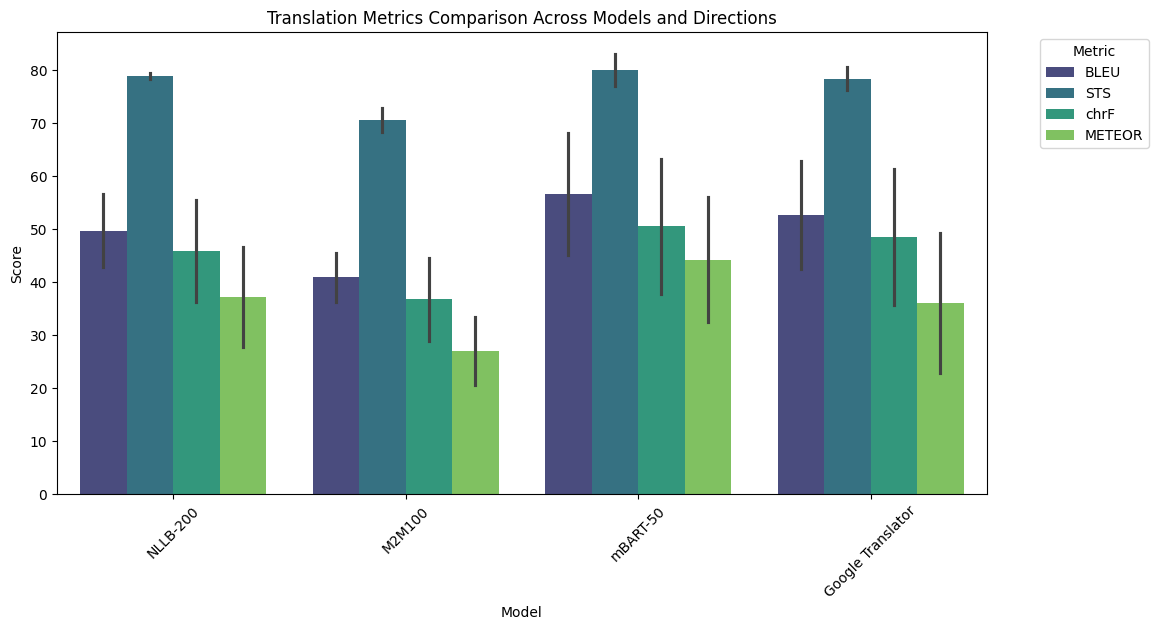

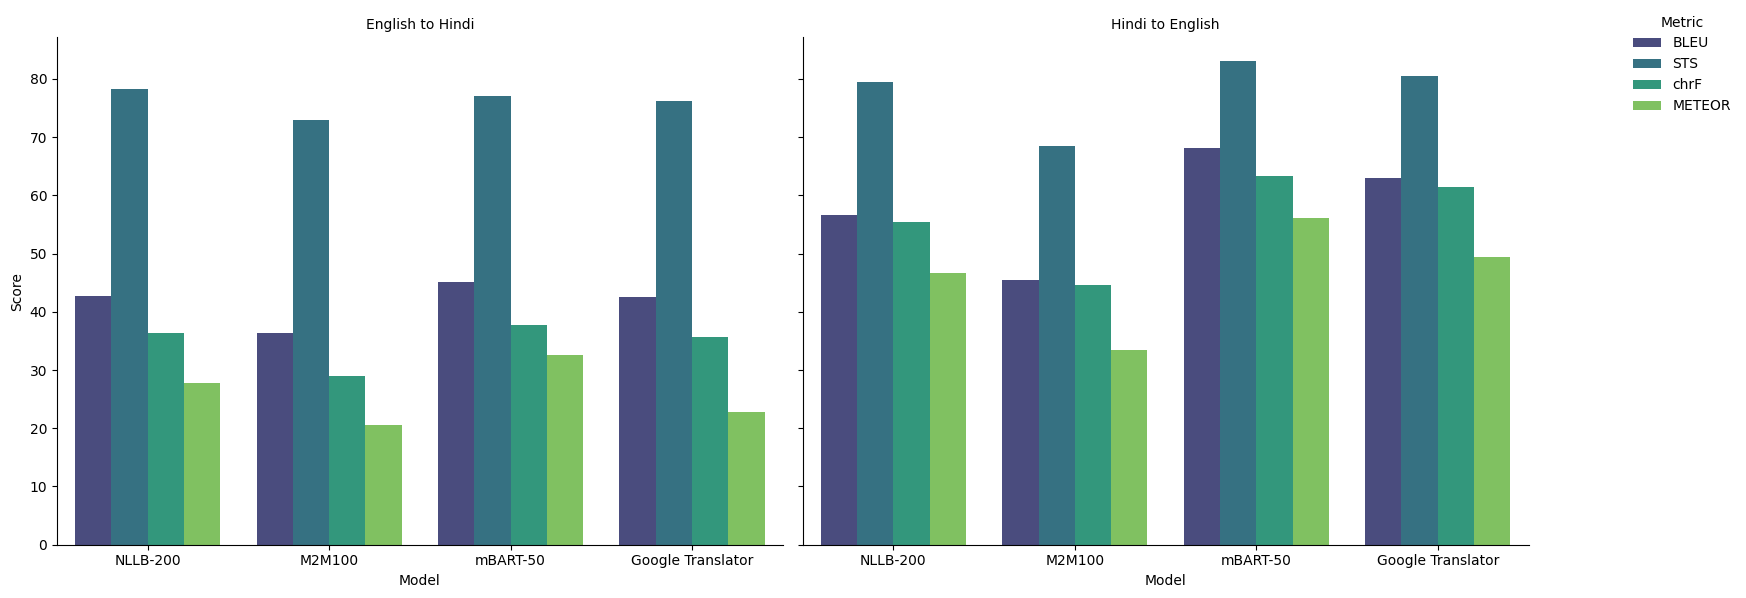

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data (you would need to input the full dataset)
data = {
    'Model': ['NLLB-200', 'M2M100', 'mBART-50', 'Google Translator'] * 2,
    'Direction': ['English to Hindi'] * 4 + ['Hindi to English'] * 4,
    'BLEU': [42.79, 36.36, 45.07, 42.57, 56.64, 45.53, 68.10, 62.90],
    'STS': [78.28, 72.86, 77.10, 76.24, 79.55, 68.40, 82.99, 80.54],
    'chrF': [36.29, 28.98, 37.77, 35.64, 55.47, 44.59, 63.26, 61.36],
    'METEOR': [27.73, 20.59, 32.50, 22.87, 46.65, 33.48, 56.03, 49.37]
}

df = pd.DataFrame(data)

# Melt the dataframe to long format
df_melted = df.melt(id_vars=['Model', 'Direction'], var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='viridis')

# Customize the plot
plt.title('Translation Metrics Comparison Across Models and Directions')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add facet for translation direction
g = sns.FacetGrid(df_melted, col='Direction', height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x='Model', y='Score', hue='Metric', palette='viridis')
g.add_legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
g.set_axis_labels('Model', 'Score')
g.set_titles('{col_name}')
plt.tight_layout()
plt.show()